In [1]:
import json
import os
import numpy as np 
import pandas as pd 
import random
import time

import cv2
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import functional as func
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models import resnet152
from torch.nn import functional as F

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from pycocotools.coco import COCO
import fiftyone as fo

In [2]:
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'

classes = 2
classes1 = 157
device

'cpu'

In [3]:
def build_model(n_model, classes):
    if 'resnet50_fpn_v2' in n_model:
        model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1')
    elif 'resnet50_fpn' in n_model:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.COCO_V1")
    else:
        print("нет такой модели ")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, classes)
    
    return model

In [4]:
# model_detect_2
modeld2 = build_model('resnet50_fpn_v2', classes).to(device)
checkpoint2 = torch.load('./chkpt_model2_d_6.pth', map_location=device)
modeld2.load_state_dict(checkpoint2['model_state_dict'])

<All keys matched successfully>

In [5]:
class ResidualBlock(nn.Module):
    """
    Creates the Residual block of ResNet.
    """
    def __init__(
        self, in_channels, out_channels, use_1x1conv=True, strides=1
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        inputs = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.conv3:
            inputs = self.conv3(inputs)
        x += inputs
        return F.relu(x)

In [6]:
def create_resnet_block(
    input_channels,
    output_channels, 
    num_residuals,
):
        resnet_block = []
        for i in range(num_residuals):
            if i == 0:
                resnet_block.append(ResidualBlock(input_channels, output_channels,
                                    use_1x1conv=True, strides=2))
            else:
                resnet_block.append(ResidualBlock(output_channels, output_channels))
        return resnet_block 

In [7]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=157):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(16), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.block2 = nn.Sequential(*create_resnet_block(16, 32, 2))
        self.block3 = nn.Sequential(*create_resnet_block(32, 64, 2))
        self.block4 = nn.Sequential(*create_resnet_block(64, 128, 2))
        self.block5 = nn.Sequential(*create_resnet_block(128, 256, 2))
        self.linear = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.linear(x)
        return x 

In [8]:
model_c = CustomResNet()
checkpoint = torch.load('./chkpt_model1c_clf_8.pth', map_location=device)
model_c.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [9]:
def predict_d(image, model, device, detection_threshold):
    transform = transforms.Compose([transforms.ToTensor(),])
    # transform the image to tensor
    im = transform(image).to(device)
    im = im.unsqueeze(0) # add a batch dimension
    outputs = model(im) # get the predictions on the image
    # get all the predicited class names
#     pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    scores = pred_scores[pred_scores >= detection_threshold].astype(np.float32)
    return boxes, scores#, pred_classes, outputs[0]['labels']

In [10]:
def predict_clf(image, boxes, model, device):
        transform = transforms.Compose([transforms.ToTensor(),])
        pred_classes = []
        for i in range(len(boxes)):
#             rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor='r', facecolor='none')
            coordinates = [boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]]
            cropped = image.crop(coordinates)
            cropped =  func.resize(cropped, [512,512])
            im = transform(cropped).to(device)
            im = im / 255.
            im = im.unsqueeze(0)
            predict = torch.argmax(model(im)).detach().cpu().numpy()
            pred_classes.append(predict)
    
        return pred_classes  

In [11]:
def labls(classes):
    with open('label_map.json') as f:
        data = json.load(f)
        
    key_list = list(data.keys())
    val_list = list(data.values())
    key = []
    for i in classes:
            if i == 156: k = 'Error'
            else: 
                position = val_list.index(i)
                k = key_list[position]
            key.append(k)
    return key

In [12]:
def draw_boxes_rtsd(boxes, scores, classes, image):
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)
        plt.imshow(image)
        plt.axis('off')
        color = ['r', 'g', 'b', 'c', 'm', 'y', 'w'] * 5
        for i in range(len(boxes)):
            if classes[i] == 'Error': continue
            rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor=color[i], facecolor='none')
            ax.add_patch(rect)
            plt.text(boxes[i][0], boxes[i][1], '{} {:.2f}'.format(classes[i], scores[i]), bbox=dict(facecolor=color[i], alpha=0.5))
        
        return image

In [13]:
img_name = '56.jpg'
detection_threshold = 0.5

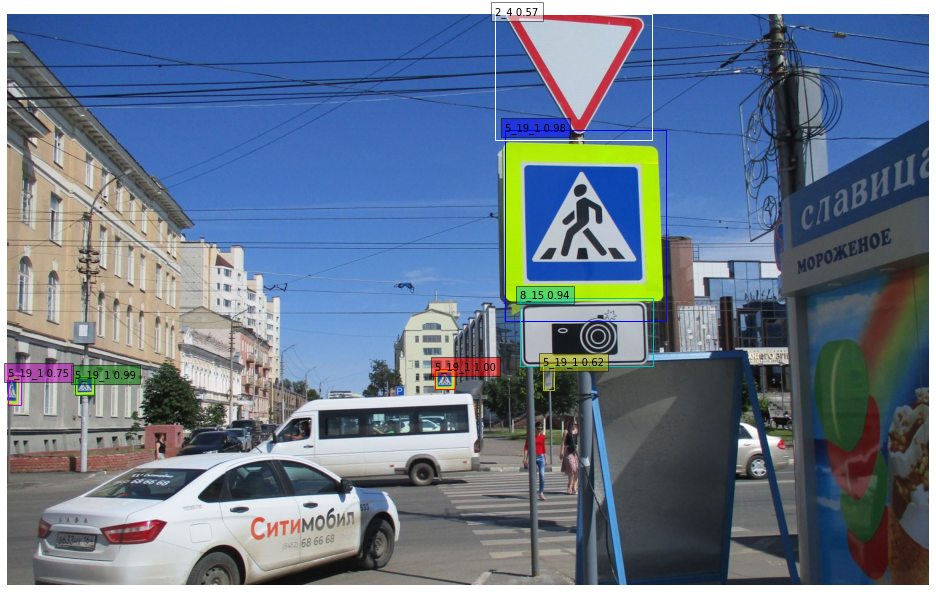

In [15]:
%matplotlib inline
modeld2.eval()
model_c.eval()
image = Image.open(img_name)
boxes, scores = predict_d(image, modeld2, device, detection_threshold)
classes = predict_clf(image, boxes, model_c, device)
cl = labls(classes)
i = draw_boxes_rtsd(boxes, scores, cl, image)
plt.imshow(i)

In [28]:
dataset_path = './'
data_path = dataset_path
val_anno_file = "val_anno.json"
val_anno_path = os.path.join(dataset_path, val_anno_file)

val_dataset1 = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=val_anno_path,
    max_samples=100,
        shuffle=True,
        seed=51,
    )

 100% |█████████████████| 100/100 [301.7ms elapsed, 0s remaining, 331.5 samples/s]      


In [34]:
threshold = 0.5

modeld2.eval()
model_c.eval()

for i, sample in enumerate(val_dataset1):
    
    image = Image.open(sample.filepath)
    image_tens = func.to_tensor(image).to(device)
    c,h,w = image_tens.shape
    
    boxes, scores = predict_d(image, modeld2, device, threshold)
    classes = predict_clf(image, boxes, model_c, device)
    cl = labls(classes)
    
    detections = []
    for label, score, bbox in zip(cl,scores, boxes):
            
            x1, y1, x2, y2 = bbox
            rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]
            
            detections.append(fo.Detection(label=label,
                                                bounding_box=rel_box,
                                                confidence=score
                                                )
                                    )
    sample['faster_rcnn_v2'] = fo.Detections(detections=detections)
    sample.save()

In [32]:
session1 = fo.launch_app(val_dataset1)

In [33]:
results = val_dataset1.evaluate_detections(
        "faster_rcnn_v2",
        gt_field="detections",
        eval_key="eval",
        compute_mAP=True,
    )
model_metrics = results.metrics()
model_metrics['mAP'] = results.mAP()
model_metrics

Evaluating detections...
 100% |█████████████████| 100/100 [783.0ms elapsed, 0s remaining, 127.7 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 100/100 [784.6ms elapsed, 0s remaining, 127.4 samples/s]      


{'accuracy': 0.775609756097561,
 'precision': 0.8153846153846154,
 'recall': 0.9408284023668639,
 'fscore': 0.8736263736263736,
 'support': 169,
 'mAP': 0.6568916164317414}